# Data Preprocessing and Library loading:

In [123]:
import json, sys, time, os, copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas
import pickle

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, roc_auc_score

plt.rcParams['figure.figsize'] = [6.4*2, 4.8*2]
sns.set_theme("paper")
sns.set_style(style="darkgrid")

In [124]:
jsonDir = "./jsonFiles"
numpyDir = "./numpyFiles"

fullTestSet = np.load(os.path.join(numpyDir,"fullTestSet.npy"))
errMSE = np.load(os.path.join(numpyDir,"ERROR_MAE_3D_T1.npy"))

with open(os.path.join(jsonDir,"file_list_3D_MAE.json"),"r") as f:
    fileList = json.load(f)

fileList = [x[:-8] for x in fileList]

print("Number of Files: ", len(fileList))

Number of Files:  31199


In [125]:
# Flattening Error volume 8x7x7 for RF

errFlat = np.zeros((errMSE.shape[0],errMSE.shape[1]*errMSE.shape[2]*errMSE.shape[3]))

for i in range(errMSE.shape[0]):
    errFlat[i] = errMSE[i,:,:,:].flatten()

print("Pre Flatten {} vs. Flattened {}".format(errMSE.shape,errFlat.shape))

Pre Flatten (31199, 8, 7, 7) vs. Flattened (31199, 392)


In [126]:
# Load in tags and additional meta data:

with open(os.path.join(jsonDir,"./reasons_split.json"),"r") as f: # Tags
    tagDict = json.load(f)

with open(os.path.join(jsonDir,"biobank_meta_float.json"),"r") as f: # Float meta data from dcm headers
    metaDict = json.load(f)

# with open(os.path.join(jsonDir,"biobank_meta_full_one_hot.json"),"r") as f: # All one hot encoded meta
#     metaDict = json.load(f)

with open(os.path.join(jsonDir,"Biobank_Bounding_Boxes.json"),"r") as f: # Bounding box meta data
    bBoxes = json.load(f)

In [127]:
# Sort through subj to make sure all meta data present


keys = list(metaDict.keys())
# keys = list(metaDict['eid'].values())
keys = [k for k in keys if k in bBoxes.keys()]
keys = [k for k in keys if k in fileList]

print("Number of Files with complete meta data: ", len(keys))

Number of Files with complete meta data:  31199


In [132]:
###### Find out the keys present in every single case:

allMetaKeys = []
instTime = ["1","2","3","4","5","6","7"]
for k in keys:
    for i in instTime:
        allMetaKeys.extend(list(metaDict[k][i].keys()))

allMetaKeysSet = set(allMetaKeys)

keysOI = []
for k in allMetaKeysSet:
    if allMetaKeys.count(k) == (len(keys)*7):
        keysOI.append(k)

print("Meta values to use: \n\n", keysOI)

##### Find out keys for new full meta data

# keysOI = list(metaDict.keys())

# print("Meta values to use: \n\n", keysOI)

Meta values to use: 

 ["Patient's Weight", 'Instance Number', '[SliceMeasurementDuration]', '[CSA Series Header Version]', 'Pixel Representation', 'Echo Train Length', 'Window Width', 'Samples per Pixel', 'Echo Number(s)', 'Pixel Bandwidth', 'Magnetic Field Strength', 'Repetition Time', "Patient's Birth Date", 'Content Date', 'Instance Creation Time', 'Percent Sampling', '[CSA Image Header Version ??]', 'Series Date', 'Percent Phase Field of View', 'Rows', 'Columns', 'High Bit', 'Slice Thickness', 'Content Time', 'Flip Angle', 'SAR', 'Instance Creation Date', '[RealDwellTime]', '[TimeAfterStart]', 'Smallest Image Pixel Value', 'Acquisition Number', 'Bits Allocated', '[CSA Image Header Version]', 'Largest Image Pixel Value', 'Device Serial Number', 'Series Number', 'Acquisition Time', 'dB/dt', 'Slice Location', 'Study Date', 'Number of Averages', 'Window Center', "Patient's Size", 'Acquisition Date', 'Imaging Frequency', 'Bits Stored', 'Echo Time', 'Inversion Time', 'Number of Phase En

In [133]:
fullDataset = False

# Create dataset (full one hot):
if fullDataset:
    subjLength = len(keys)
    dataLength = len(keysOI)
    bBoxesLength = 16
    errLength = errFlat.shape[1]

    ownDataset = np.zeros((subjLength,dataLength + bBoxesLength + errLength))

    k0 = list(tagDict.keys())[0]
    tags = np.zeros((subjLength,len(tagDict[k0])))

    for i,k in enumerate(keys):
        sys.stdout.write("\r[{}/{}]".format(i,len(keys)))
        metaList = []
        for kOI in keysOI:
            metaList.append(metaDict[kOI][str(i)])

        try:
            metaList.extend(bBoxes[k]["Body"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Liver"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Lungs"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Heart"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        charArr = np.char.find(fileList,k)
        charIdx = np.argwhere(charArr == 0)[0,0]
        
        assert(type(charIdx) == np.int64)
        errMeta = list(errFlat[charIdx,:])

        metaList.extend(errMeta)

        ownDataset[i,:] = np.array(metaList)
        if k in tagDict.keys():
            tags[i] = np.array(tagDict[k])

    ownDataset = (ownDataset,tags)

    print("\n Meta Data for Subj0: {} \n Tag for Subj0: {}".format(ownDataset[0][0][:10],ownDataset[1][0]))

# Create dataset (float only):
else:
    subjLength = len(keys)
    dataLength = len(keysOI)*len(instTime)
    print("Data Length: {}\n".format(dataLength))
    bBoxesLength = 16
    errLength = errFlat.shape[1]

    ownDataset = np.zeros((subjLength,dataLength + bBoxesLength + errLength))

    k0 = list(tagDict.keys())[0]
    tags = np.zeros((subjLength,len(tagDict[k0])))

    for i,k in enumerate(keys):
        sys.stdout.write("\r[{}/{}]".format(i,len(keys)))
        metaList = []
        for kOI in keysOI:
            for inst in instTime:
                metaList.append(metaDict[k][inst][kOI])
        try:
            metaList.extend(bBoxes[k]["Body"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Liver"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Lungs"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Heart"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        charArr = np.char.find(fileList,k)
        charIdx = np.argwhere(charArr == 0)[0,0]
        
        assert(type(charIdx) == np.int64)
        errMeta = list(errFlat[charIdx,:])

        metaList.extend(errMeta)

        ownDataset[i,:] = np.array(metaList)
        if k in tagDict.keys():
            tags[i] = np.array(tagDict[k])

    ownDataset = (ownDataset,tags)

    print("\n Meta Data for Subj0: {} \n Tag for Subj0: {}".format(ownDataset[0][0][:10],ownDataset[1][0]))

Data Length: 364

[31198/31199]
 Meta Data for Subj0: [75. 75. 75. 75. 75. 75. 75.  1.  2.  3.] 
 Tag for Subj0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [134]:
print("Header Meta Data: {} \nBounding Box Meta Data: {} \nImage Recon Errors: {} \n".format(dataLength,bBoxesLength,errLength))

Header Meta Data: 52 
Bounding Box Meta Data: 16 
Image Recon Errors: 392 



# Train Random Forests:

## All Data:

In [135]:
# Hyperparameters:

testSize = 0.5
n_estimators = 100
max_depth = 10
tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']
numAvgs = np.arange(0,20,1)


In [136]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y = y0[:,idx]
        X = x0[:,:]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[239/240]

In [137]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  20.000000    20.000000        20.000000       20.000000   
mean    0.736574     0.999606         0.848839        0.808944   
std     0.008077     0.000028         0.006500        0.014571   
min     0.721417     0.999559         0.838819        0.785412   
25%     0.731263     0.999587         0.844145        0.799948   
50%     0.736306     0.999608         0.847436        0.807033   
75%     0.741470     0.999622         0.853900        0.816843   
max     0.754524     0.999652         0.859690        0.839286   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        20.000000  20.000000       20.000000  20.000000  20.000000   
mean          0.785269   0.923340        0.901530   0.814791   0.911442   
std           0.021160   0.004230        0.003488   0.012191   0.004934   
min           0.735333   0.914193        0.895714   0.794178   0.902985   
25%           0.770610   0.921

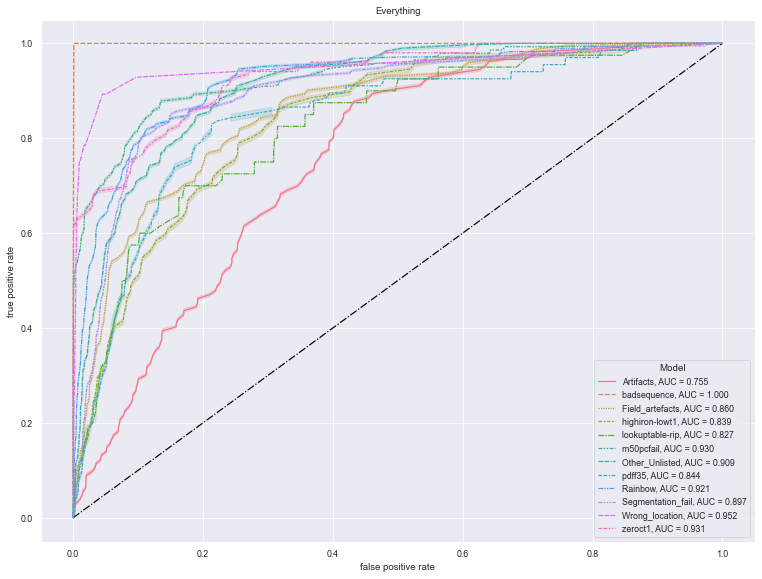

In [138]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Everything")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [139]:
# Save Models
saveDir = "./models/Random Forests/All_Meta/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Meta + Bboxes:

In [140]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y = y0[:,idx]
        X = x0[:,:-errLength]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[239/240]

In [141]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  20.000000    20.000000        20.000000       20.000000   
mean    0.611761     0.999678         0.798366        0.547451   
std     0.012658     0.000046         0.006939        0.013298   
min     0.587918     0.999589         0.788787        0.529897   
25%     0.605099     0.999645         0.792876        0.538417   
50%     0.611314     0.999673         0.798490        0.543679   
75%     0.620343     0.999706         0.802124        0.554730   
max     0.634150     0.999772         0.812711        0.571366   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        20.000000  20.000000       20.000000  20.000000  20.000000   
mean          0.717348   0.718965        0.656734   0.736245   0.880996   
std           0.015179   0.009731        0.012244   0.008928   0.005605   
min           0.687739   0.701183        0.629660   0.713590   0.871780   
25%           0.710157   0.712

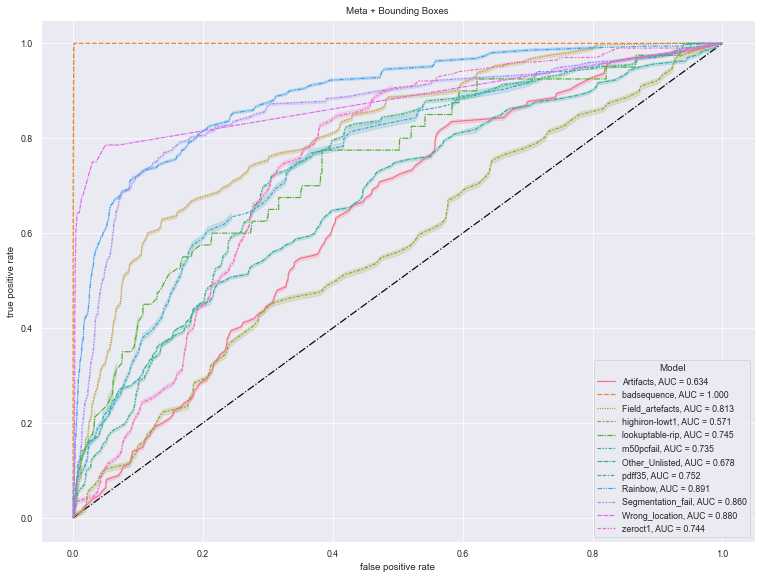

In [142]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Meta + Bounding Boxes")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [143]:
# Save Models
saveDir = "./models/Random Forests/Meta_BBoxes/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Meta Only:

In [144]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y = y0[:,idx]
        X = x0[:,:-(bBoxesLength+errLength)]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[239/240]

In [145]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  20.000000    20.000000        20.000000       20.000000   
mean    0.600502     0.999688         0.795420        0.519687   
std     0.015310     0.000038         0.005492        0.020308   
min     0.572043     0.999580         0.783243        0.490409   
25%     0.588850     0.999667         0.792238        0.505160   
50%     0.601452     0.999697         0.795631        0.516956   
75%     0.613309     0.999713         0.799721        0.536176   
max     0.621576     0.999737         0.804595        0.553731   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        20.000000  20.000000       20.000000  20.000000  20.000000   
mean          0.720169   0.680308        0.620163   0.698690   0.868819   
std           0.020437   0.009297        0.012149   0.010595   0.006368   
min           0.693417   0.664567        0.593905   0.674688   0.853331   
25%           0.703076   0.674

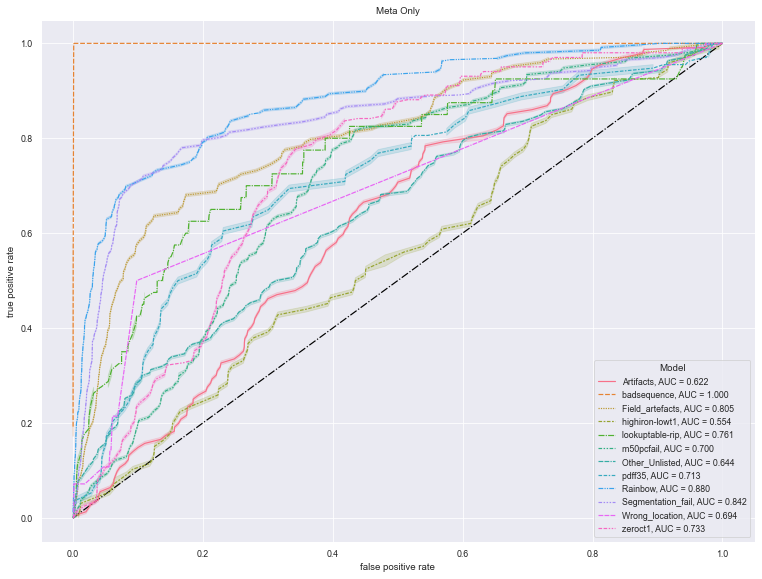

In [146]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Meta Only")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [147]:
# Save Models
saveDir = "./models/Random Forests/Meta_Only/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Error Only: 

In [148]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y = y0[:,idx]
        X = x0[:,-errLength:]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[239/240]

In [149]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  20.000000    20.000000        20.000000       20.000000   
mean    0.739115     0.998292         0.849885        0.841207   
std     0.008450     0.000055         0.007774        0.016592   
min     0.728387     0.998207         0.835595        0.801223   
25%     0.732924     0.998250         0.846442        0.833799   
50%     0.735771     0.998292         0.848732        0.844242   
75%     0.744293     0.998346         0.855801        0.852089   
max     0.758879     0.998392         0.861187        0.863862   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        20.000000  20.000000       20.000000  20.000000  20.000000   
mean          0.801453   0.913960        0.905025   0.831767   0.899771   
std           0.020210   0.002687        0.002730   0.013475   0.004052   
min           0.756017   0.908595        0.899603   0.799816   0.890248   
25%           0.795621   0.912

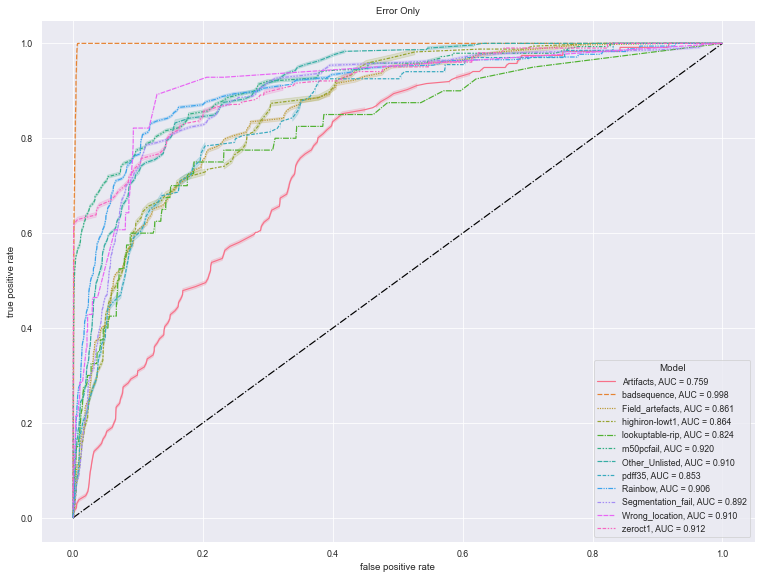

In [150]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Error Only")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [151]:
# Save Models
saveDir = "./models/Random Forests/Error_Only/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Error + BBoxes:

In [152]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y = y0[:,idx]
        X = x0[:,-(bBoxesLength+errLength):]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[239/240]

In [153]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  20.000000    20.000000        20.000000       20.000000   
mean    0.737287     0.998778         0.848518        0.844526   
std     0.008380     0.000051         0.006061        0.015223   
min     0.722184     0.998681         0.836202        0.814807   
25%     0.730538     0.998751         0.844232        0.837653   
50%     0.737516     0.998784         0.847162        0.843420   
75%     0.741607     0.998814         0.851671        0.853751   
max     0.757734     0.998871         0.861008        0.877092   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        20.000000  20.000000       20.000000  20.000000  20.000000   
mean          0.804344   0.917082        0.908169   0.831115   0.905856   
std           0.028296   0.002338        0.003620   0.012092   0.005319   
min           0.721489   0.912247        0.903224   0.801894   0.895942   
25%           0.794206   0.915

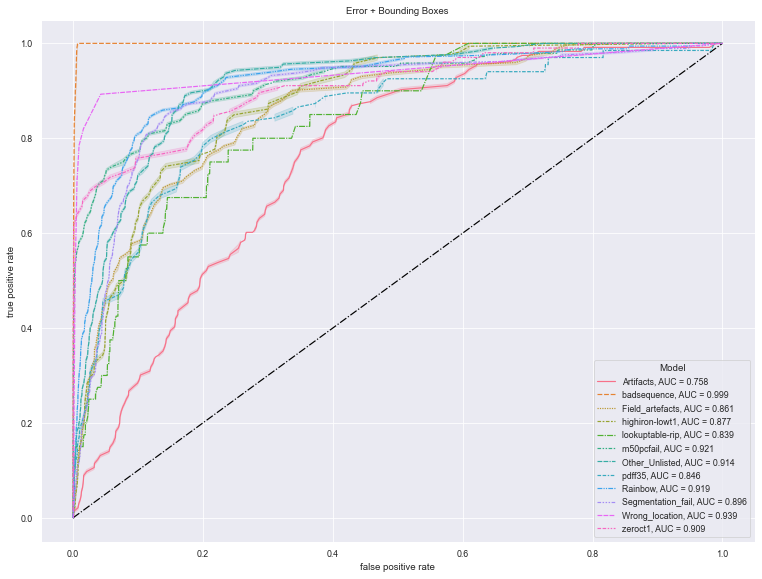

In [154]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Error + Bounding Boxes")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [155]:
# Save Models
saveDir = "./models/Random Forests/Error_BBoxes/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

# AUC Comparisons:

In [156]:
import seaborn as sns
import pandas as pd

loadDir = "./models/Random Forests/"

rfList = os.listdir(loadDir)

fullDict = {}
for fol in rfList:
    fullDict[fol] = {}
    with open(os.path.join(loadDir,fol,"metrics.json")) as f:
        metrics = json.load(f)
    for k1 in metrics.keys():
        avgAUC = []
        for k2 in metrics[k1].keys():
            avgAUC.append(metrics[k1][k2])
        fullDict[fol][k1] = np.mean(avgAUC)

df = pandas.DataFrame(fullDict)
print(df)

plt.figure()
sns.lineplot(data=df,markers=True)
plt.xlabel("Class")
plt.ylabel("AUC of ROC")
plt.xticks(rotation=45)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './models/Random Forests/Float_Categorical\\metrics.json'

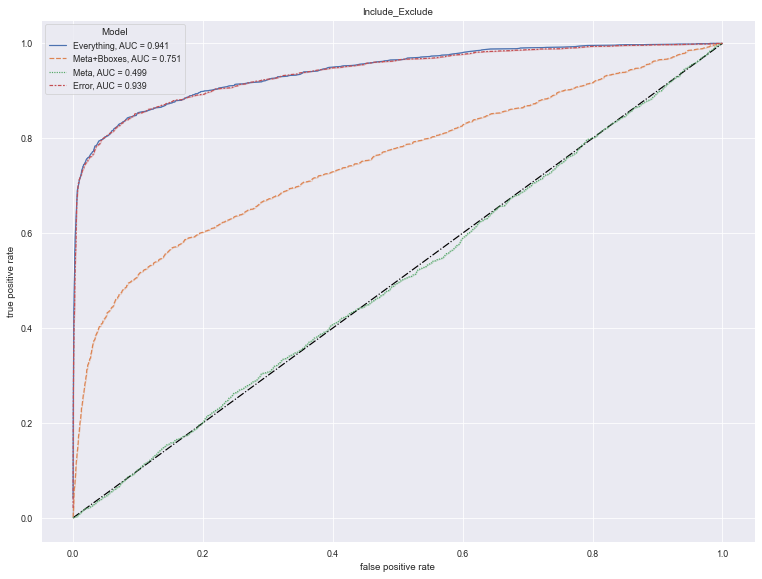

In [121]:
x0, y0 = ownDataset

newY = np.zeros(y0.shape[0])
for i in range(y0.shape[0]):
    if np.sum(y0[i,:]) >= 1:
        newY[i] = 1

y0 = newY

modelsArr = []
fprArr = []
tprArr = []
clfDict = {}

names = ["Everything","Meta+Bboxes","Meta","Error"]
features = [(0,-1),(0,-errFlat.shape[1]),(0,-(16+errFlat.shape[1])),(-errFlat.shape[1],-1)]

for name,(m,n) in zip(names,features):
    clf = RandomForestClassifier(n_estimators=100,max_depth=10,verbose=False,n_jobs=-1)

    y = y0
    if n == -1:
        X = x0[:,m:]
    else:
        X = x0[:,m:n]

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.4,random_state=42)

    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    probs = clf.predict_proba(X_test)

    fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
    auc_score = roc_auc_score(y_test,probs[:,1])

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    clfDict[name] = clf

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

plt.figure()
plt.title("Include_Exclude")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

# Feature Importance:

In [122]:

featuresPlot = {}
for name in tagNames:
    featuresPlot[name] = []

for idx,name in enumerate(tagNames):
    print("#"*50)
    print(name)
    print("#"*50)

    clf = clfDict[name]
    instCnt = 0
    featCnt = -1
    for i,fImp in enumerate(clf.feature_importances_):
        if i % 7 == 0:
            instCnt = 0
            featCnt += 1
        if fImp > 0.005:
            featuresPlot[name].append((keysOI[featCnt],instTime[instCnt]))
            print("{},\t {}, \t\t\t {}".format(keysOI[featCnt],instTime[instCnt],fImp))
        instCnt += 1
    print("#"*50)


##################################################
Artifacts
##################################################


KeyError: 'Artifacts'

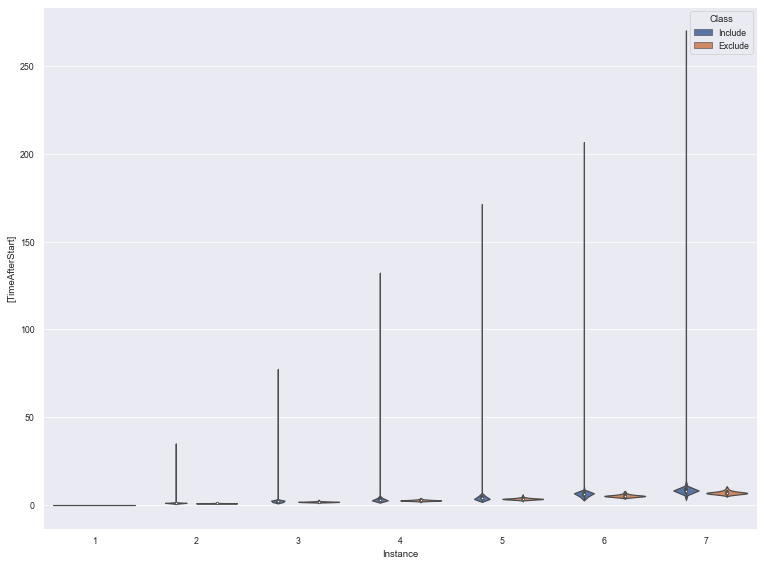

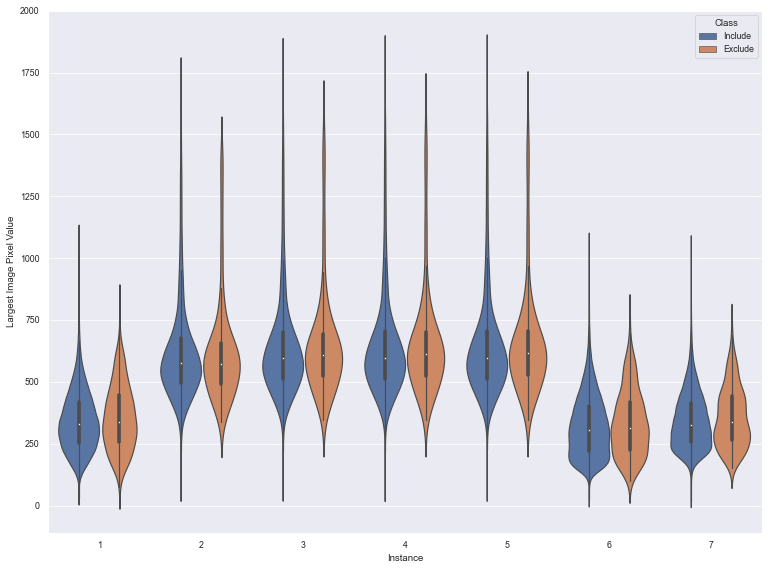

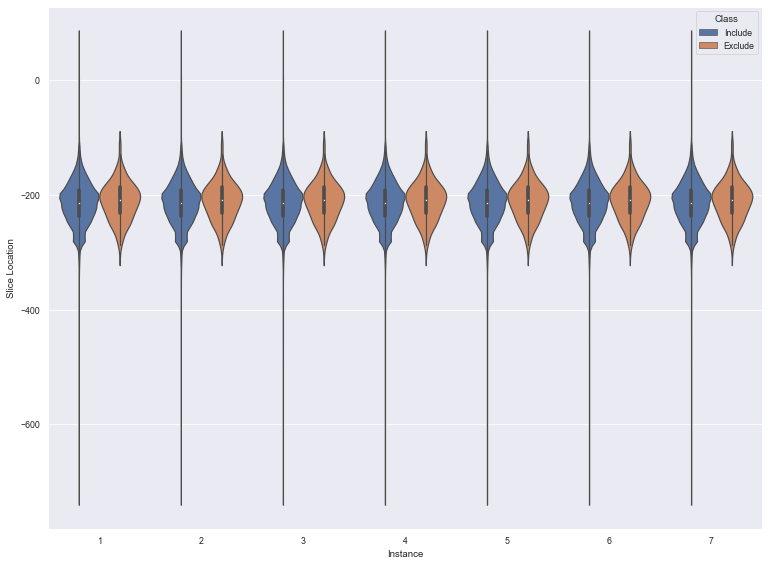

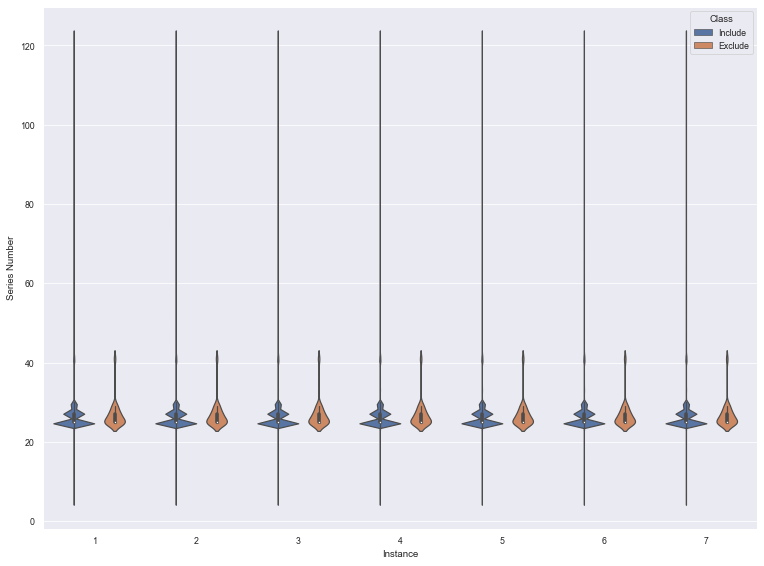

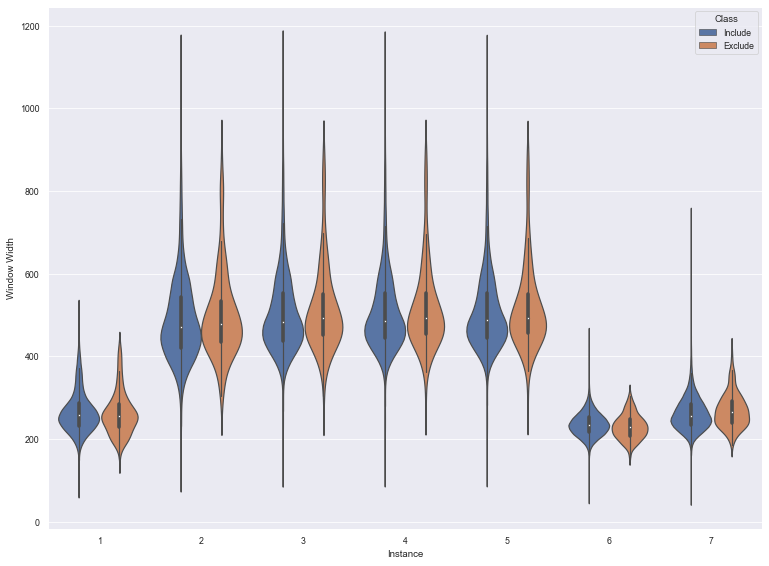

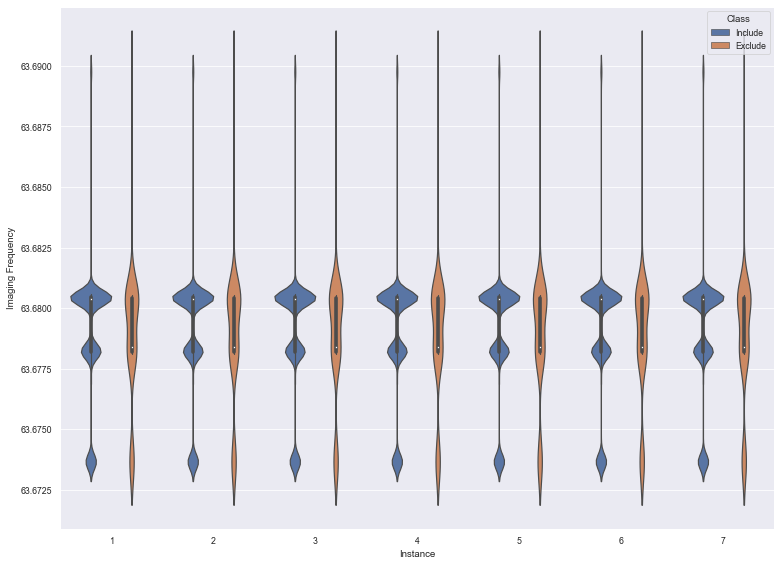

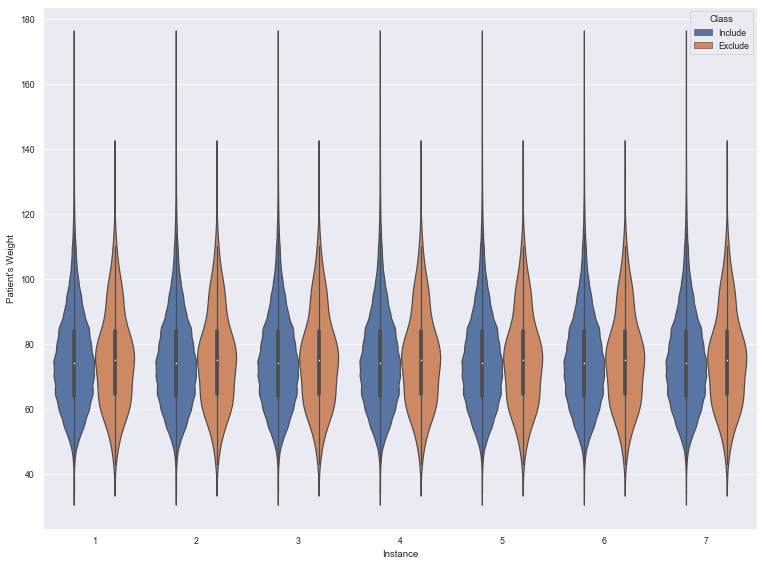

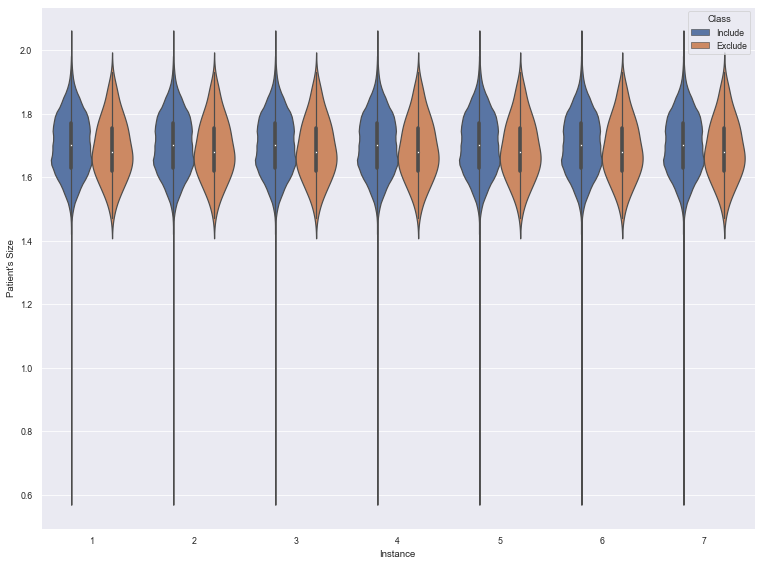

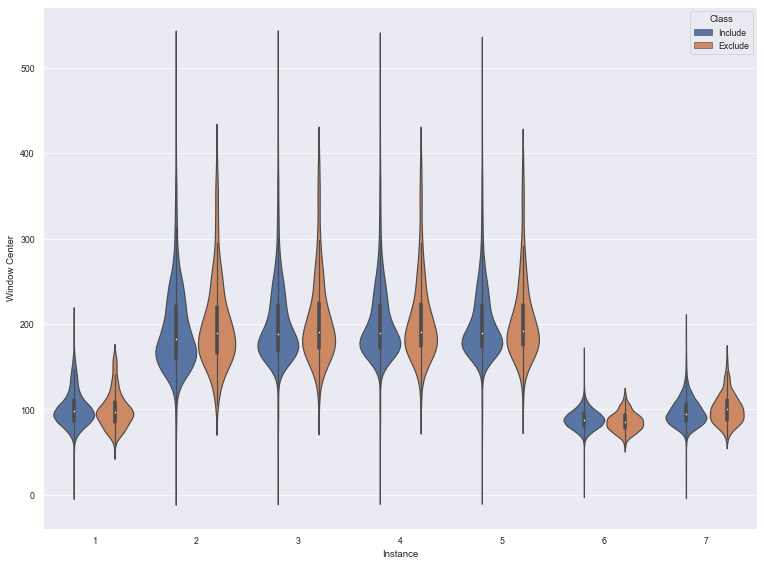

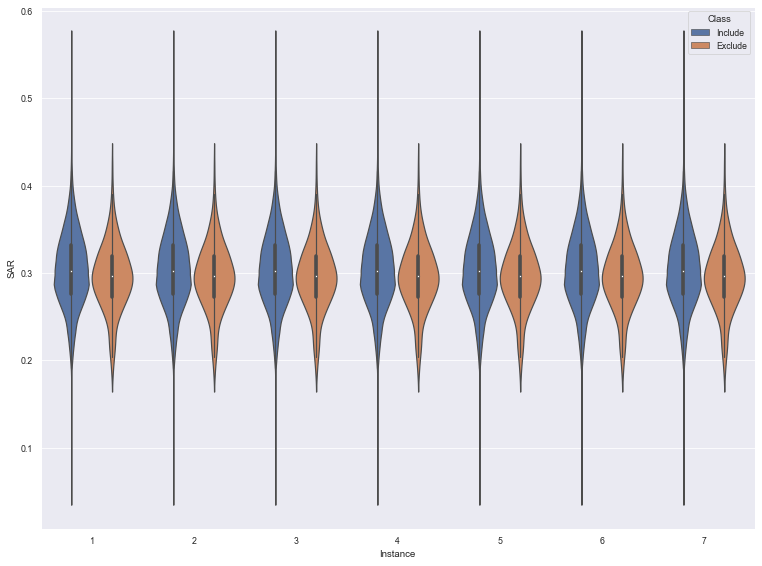

In [119]:
name = "Segmentation_fail"

features = [x[0] for x in featuresPlot['Artifacts']]
features = list(set(features))

for topFeature in features:
    metaList = []
    instTimeList = []
    tagListStr = []
    for i,k in enumerate(metaDict.keys()):
        for inst in instTime:
            instTimeList.append(inst)
            metaList.append(metaDict[k][inst][topFeature])
            if k in tagDict.keys():
                issues = tagDict[k]
                if issues[idx] == 1:
                    tagListStr.append("Exclude")
                else:
                    tagListStr.append("Include")
            else:
                tagListStr.append("Include")

    d = {topFeature:metaList,"Instance":instTimeList,"Class":tagListStr}
    df = pandas.DataFrame(data=d)

    sns.violinplot(x="Instance",y=topFeature,hue="Class",split=False,data=df)
    plt.show()
